# Decision Tree Plots


## TODOs

- adapt plots, columns plotted not applicable to my experiment!
- TODO do column plots with subplots (to save space, no y labels etc!)
- TODO show line style in legends
- TODO add legend background

In [3]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker
sns.set_style("ticks")
sns.set_context({"figure.figsize": (4.5, 3)})

## Load data

(Data files can be multiple GB. If files are small then use uncompressed files --> faster!)

In [7]:
#print(np.version.version) # numpy version 1.15.2
print("\n<--- URS and DT experiment --->")
%time df = pd.read_pickle("data/DT_selection.pkl", compression="bz2")  # -r 100
print(df) # row 0-181 is URS, rest DT
df.to_csv("data/DT_selection.csv", index=False)




<--- URS and DT experiment --->
CPU times: user 4.66 ms, sys: 2.32 ms, total: 6.98 ms
Wall time: 13.5 ms
     alpha  conf_id  degree  epsilon   error error_metric  error_value  \
0      0.1        1       2      0.1     MSE          NaN     2.974657   
1      0.1        1       2      0.1    RMSD          NaN     1.724720   
2      0.1        1       2      0.1  NRMSDM          NaN     0.812110   
3      0.1        1       2      0.1  NRMSDR          NaN     0.348428   
4      0.1        1       2      0.1     MSE          NaN     1.957039   
5      0.1        1       2      0.1    RMSD          NaN     1.398942   
6      0.1        1       2      0.1  NRMSDM          NaN     0.658713   
7      0.1        1       2      0.1  NRMSDR          NaN     0.282615   
8      0.1        1       2      0.1     MSE          NaN     1.833429   
9      0.1        1       2      0.1    RMSD          NaN     1.354042   
10     0.1        1       2      0.1  NRMSDM          NaN     0.637571   
11    

In [9]:
print("Selectors:")
print(list(set(list(df["selector_conf"]))))
print("\n\nPredictors:")
print(list(set(list(df["predictor_conf"]))))
print("Error Metrics:")
print(list(set(list(df["error"]))))


Selectors:
['URS', "DTS_error_metric='mse'-initial_samples=4-intial_samples=10-max_depth=None-max_features_split=1.0-min_error_gain=0.001-min_samples_split=2-regression='default'-weight_size=0.2"]


Predictors:
['SVRP_a=0.1-dgr=2-e=0.1-mtd=2']
Error Metrics:
['MSE', 'NRMSDR', 'NRMSDM', 'RMSD']


### Helper Functions

In [10]:
def _cartesian_product(p_dict):
    p_names = sorted(p_dict)
    return [dict(zip(p_names, prod)) for prod in it.product(
        *(p_dict[n] for n in p_names))]

def _generate_filters(df, column_lst):
    """
    config defines arbitrary column names over which we want to iterate
    to create multiple plots, we fetch the possible values of each column
    from the dataset, and compute a float list (cartesian_product) of
    configuration combinations to be plotted
    """
    # extract possible values
    filter_dict = dict()
    for column in column_lst:
        filter_dict[column] = list(set(df[column]))
    # all combinations
    return _cartesian_product(filter_dict)

def _filter_df_by_dict(df, filter_dict):
    """
    do some Pandas magic to dynamically filter df by given dict
    filter_dict = {"column1": "value", "column2": ...}
    """
    return df.loc[
         (df[list(filter_dict)] == pd.Series(filter_dict)).all(axis=1)]

def _get_selector_name(sconf):
    if "URS" in sconf:
        return "URS"
    if "DTS" in sconf:
        return "DTS"
    return sconf.split("_")[0]

def _get_predictor_name(pconf):
    return pconf.split("_")[0]

def _get_error_name(err):
    if err == "MSE":
        return "mean squared error (MSE)"
    if err == "NRMSDR" or err == "NRMSDM":
        return "normalized RMSD"
    if err == "R":
        return "coefficient of determination ($R^2$)"
    return err

def _rewrite_legend_texts(leg, rewrite_func):
    for t in leg.texts:
        t.set_text(rewrite_func(t.get_text()))
    

In [11]:
def error_plot(df, filter_dict,
                  title="selector comparison",
                  x="k_samples", y="error_value",
                  hue="selector_conf", # errors are based on this grouping
                  error_bars=95, # ="sd" or =95 (for ci)
                  y_limit=None,
                  x_label="k samples",
                  y_label="error",
                  y_ticks_disabled = False,  # for multi column plots
                  fig_width=6,
                  fig_height=5,
                  legend_loc="best",
                  legend_ncol=1,
                  legend_rewrite_func=_get_predictor_name,
                  path=None):
    sns.set_style("ticks", rc={"legend.frameon": False})
    sns.set_context("paper",
                    font_scale=1.6,
                    rc={
                    "lines.linewidth": .7
                    })
    # filters (one filter per plot)
    if isinstance(filter_dict, dict):
        filter_dict_list = [filter_dict]
    else:
        filter_dict_list = filter_dict
    # iterate over all filters to gen. diff. plots
    for f in filter_dict_list:
        # select data to be plotted
        dff = _filter_df_by_dict(df, f)
        if len(dff) < 1:
            print("Filter {} returned 0 data entires.".format(f))
            continue  # nothing to plot
        print("Filtered plot data has {} entries".format(len(dff)))
        fig, ax = plt.subplots(
            figsize=(fig_width,
                     fig_height),
                     dpi=300)
        # do plot
        sns.pointplot(ax=ax,
                      data=dff,
                      x=x,
                      y=y,
                      hue=hue,
                      ci=error_bars,  # ci="sd" or ci=95
                      capsize=.3,
                      markers=["o", "s", "^", "v", "D", "p", "d", "P", "X" "*"],
                      linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":"],
                      #palette="hls",
                      color="dimgray"  # "darkgray"=different grays
                     )

        # custom markers (seaborn does not support it well)
        plt.setp(ax.collections, sizes=[50], facecolor='none')  
        # create legend
        leg = ax.legend(loc=legend_loc, ncol=legend_ncol)
        _rewrite_legend_texts(leg, legend_rewrite_func)
        #fig.suptitle(title)
        ax.set_title(title)
        ax.set_ylabel(y_label)
        # remove y ticks
        if y_ticks_disabled:
            #ax.set_yticks([])
            ax.set_yticklabels([])
        ax.set_xlabel(x_label)
        if y_limit is not None:
            ax.set_ylim(y_limit)
        if path is not None:
            plt.savefig(path, bbox_inches="tight")
        plt.show()

### Selector Analysis

Filtered plot data has 90 entries


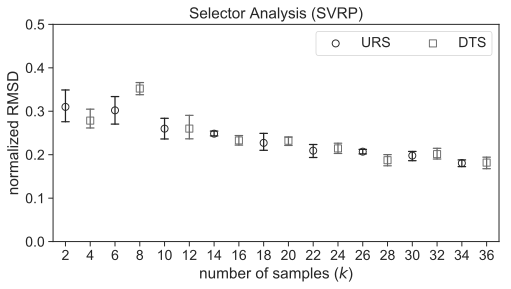

Filtered plot data has 90 entries


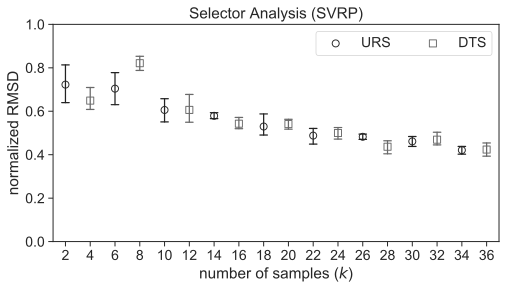

In [24]:
ERRORS = ['NRMSDR', 'NRMSDM']
SELECTORS = ['URS', 'DTS']
PREDICTORS = [#'SVRPRK_a=0.1-dgr=2-e=0.1-mtd=2',
              #'SVRPLK_a=0.1-dgr=2-e=0.1-mtd=2',
              'SVRP_a=0.1-dgr=2-e=0.1-mtd=2'
             ]

# remove unneeded selectors
#heidi: dff = df[df["selector_conf"].isin(SELECTORS)]
dff = df[df["selector"].isin(SELECTORS)]

for pred in PREDICTORS:
    for err in ERRORS:
        error_plot(
                dff, 
                {#"topology": topo,
                 "predictor_conf": pred,
                 "error": err
                },
                title="Selector Analysis ({})".format(_get_predictor_name(pred)),
                x_label = "number of samples ($k$)",
                y_label = _get_error_name(err),
                y_limit=[0.0, .5] if err == "NRMSDR" else [0, 1],
                fig_width=8,
                fig_height=4,
                legend_ncol=2,
                legend_rewrite_func=_get_selector_name,
                path="plots/selector_study_{}_{}.pdf".format(_get_predictor_name(pred), err),
            )